# Advanced Lane Finding Project
*** By NK Zou ***  
  
### Table of Contents
1.1 Camera Calibration  
1.2 Binary Image with ColorTransforms & Gradients  
1.3 Rectify Binary image with PerspectiveTransform (Birds-Eye View)  
2.1 Pipeline  
2.2 Detected LaneBoundaries, LaneCurvature and VehiclePosition on image  
2.3 Detected LaneBoundaries, LaneCurvature and VehiclePosition on moive  

### 1.1 Camera Calibration

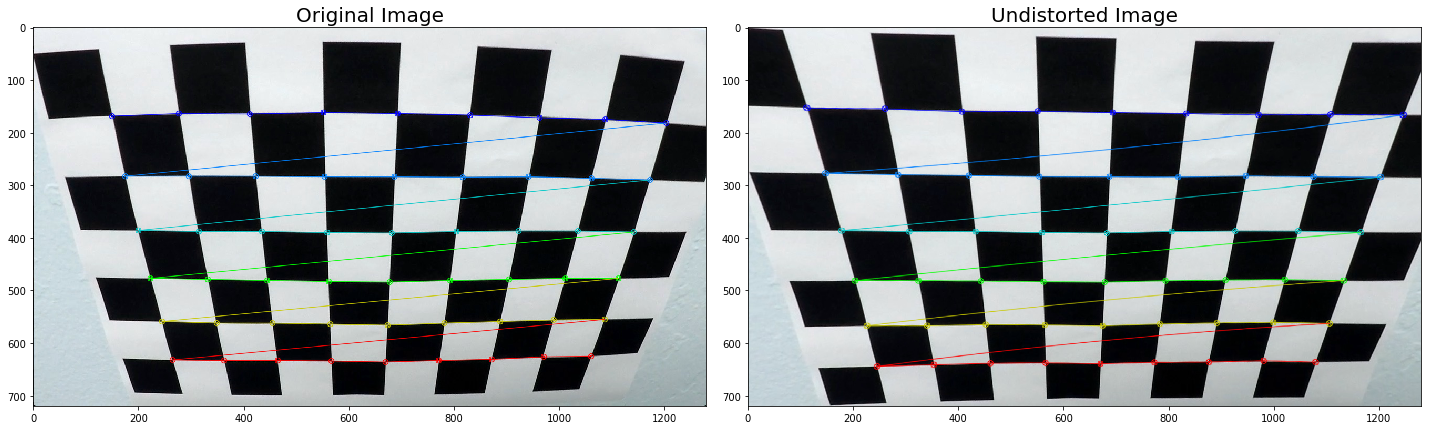

In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np

### 1- function set
# the most important step, get the matrix and distortion params of camera
def cali_param(path, cshape):                                                  # cshape: Shape of grid used in the latter
    objpoints = []                                                                    # Object & image points collections
    imgpoints = []
    filenames = os.listdir(path)                                                                              # load file
    for name in filenames:        # calibration points (objpoints, imgpoints) from images via cv2.findChessboardCorners()
        img = cv2.imread(path + name)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)                                                      # grayscale img
        op = np.zeros((cshape[0] * cshape[1], 3), np.float32)                         # theoretical grid, get objectpoint
        op[:, :2] = np.mgrid[0:cshape[0], 0:cshape[1]].T.reshape(-1, 2)
        ret, corners = cv2.findChessboardCorners(gray, cshape, None)                               # corners in the image
        if ret:
            objpoints.append(op)
            imgpoints.append(corners)
    # calibration matrix and distortion from images via cv2.calibrateCamera()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    return mtx, dist

def undistort(name, cshape, mtx, dist):                   # just for test purpose, we don't use this function on pipeline
    img = cv2.imread(name)
    ret, corners = cv2.findChessboardCorners(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cshape, None)
    draw_image = cv2.drawChessboardCorners(img, cshape, corners, ret)           # remove this if no draw pionts and lines
    undist = cv2.undistort(draw_image, mtx, dist, None, mtx)
    return img, undist

### 2- calibration & undistorted testing, need to use mtx and dist params on pipeline
path = 'camera_cal/'
filenames = os.listdir(path)
cshape = (9, 6)                     # the number of inside corners in x & y, change this param to undistort another imgae
mtx, dist = cali_param(path, cshape)
image, undist = undistort(path + filenames[11], cshape, mtx, dist)

### 3- plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))                 # if ax>2, use subplots(n_ax), figsize=width*height
fig.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undist, cmap='gray')
ax2.set_title('Undistorted Image', fontsize=20)

### 1.2 Binary Image with ColorTransform & Gradients

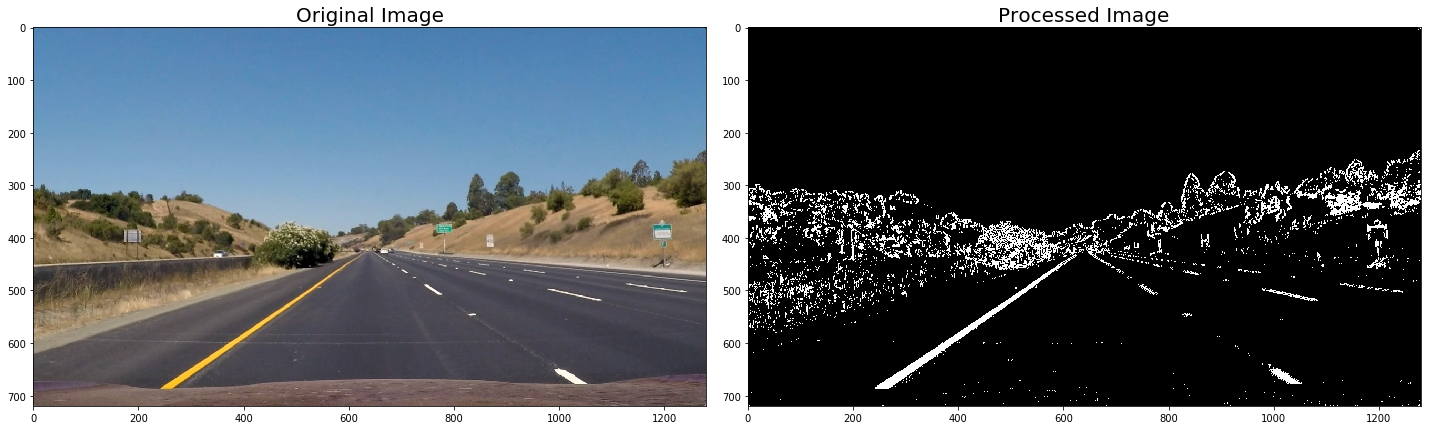

In [2]:
import matplotlib.image as mpimg

### 1- function set, binary image with hls and gradients
def combined_binary(img):
    # Threshold color channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    s_thresh_min = 120
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Threshold x gradient
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)                                       # Take the derivative in x
    abs_sobelx = np.absolute(sobelx)           # absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

### 2- binary image with hls & x gradient
image = mpimg.imread('images/straight_lines1.jpg')
binary = combined_binary(image)

### 3- plotting
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,30))
fig.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image',fontsize=20)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Processed Image',fontsize=20)

### 1.3 Rectify Binary image with PerspectiveTransform (Birds-Eye View)

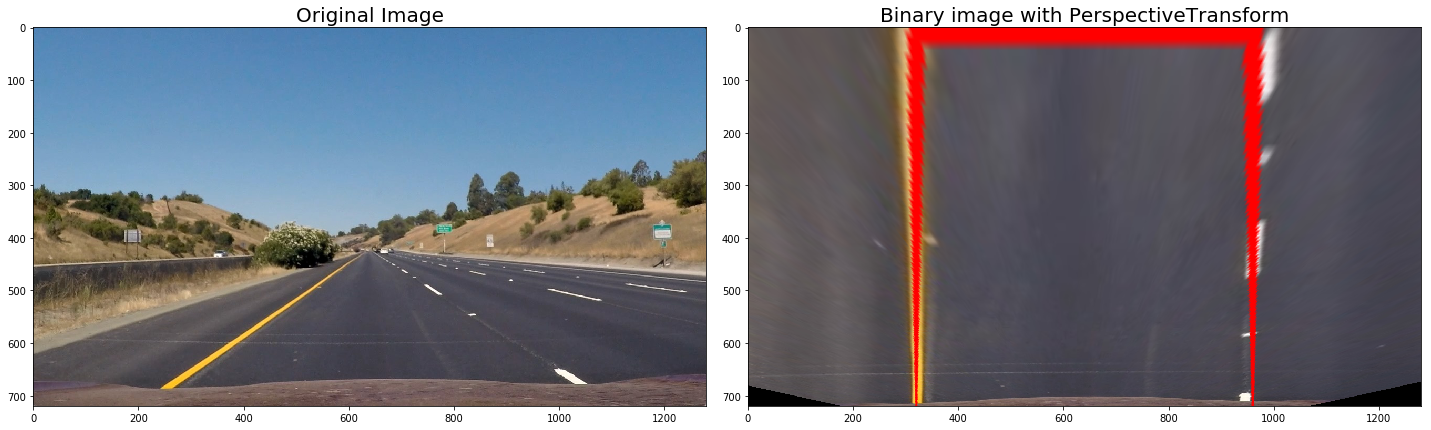

In [3]:
### 1- function set, # just for compare purpose, we don't use this function on pipeline since not need draw lines
# compute perspective transform from source and destination points
def perspective_transform(img):
    img_size = (img.shape[1], img.shape[0])
    src_points = np.float32([[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
                             [((img_size[0] / 6) - 10), img_size[1]],
                             [(img_size[0] * 5 / 6) + 60, img_size[1]],
                             [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst_points = np.float32([[(img_size[0] / 4), 0],
                             [(img_size[0] / 4), img_size[1]],
                             [(img_size[0] * 3 / 4), img_size[1]],
                             [(img_size[0] * 3 / 4), 0]])
    mtx_perp = cv2.getPerspectiveTransform(src_points, dst_points)
    return mtx_perp

# draw collection of lines to compare with undistorted lane lines, optional funtion
def draw_lines(img, color=[255, 0, 0], thickness=2):
    img_size = (img.shape[1], img.shape[0])
    src_points = np.float32([[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
                             [((img_size[0] / 6) - 10), img_size[1]],
                             [(img_size[0] * 5 / 6) + 60, img_size[1]],
                             [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    l = len(src_points)
    lines = [[[src_points[i][0], src_points[i][1], src_points[(i+1) % l][0],
               src_points[(i+1) % l][1]]] for i in range(l)]
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

# warp image via transform matrix
def warp_image(img, mtx_perp, flags=cv2.INTER_LINEAR):
    img_size = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(img, mtx_perp, img_size, flags=cv2.INTER_LINEAR)

# test perspective transform function
def birdeye_test(img):
    img_size = (img.shape[1], img.shape[0])
    src_points = np.float32([[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
                             [((img_size[0] / 6) - 10), img_size[1]],
                             [(img_size[0] * 5 / 6) + 60, img_size[1]],
                             [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst_points = np.float32([[(img_size[0] / 4), 0],
                             [(img_size[0] / 4), img_size[1]],
                             [(img_size[0] * 3 / 4), img_size[1]],
                             [(img_size[0] * 3 / 4), 0]])
    mtx_perp = cv2.getPerspectiveTransform(src_points, dst_points)
    draw_lines(img, thickness=2)                        # no need to use this line if don't want to compare with lane lines
    birdeye = warp_image(img, mtx_perp, flags=cv2.INTER_LINEAR)
    return birdeye

### 2- binary image with perspective transform
image = mpimg.imread('images/straight_lines1.jpg')
perp_scaling = np.float32([0.042, 0.006])
mtx_perp = perspective_transform(image)
undist_img = cv2.undistort(image, mtx, dist, None, mtx)  # if no undistort image in here, will affect accuracy in next step
birdeye = birdeye_test(undist_img)

### 3- plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(birdeye)
ax2.set_title('Binary image with PerspectiveTransform', fontsize=20)

### 2.1 Pipeline

In [4]:
### 1- define a class to sava all of detected point of lane lines
class line():
    def __init__(self, imgHeight):
        self.points = []
        self.fitLine = []
        self.N = 10                             # number of past instances to keep
        self.imgHeight = imgHeight
        self.numVertices = 20
        self.y = np.linspace(0,imgHeight, self.numVertices)
    
    def savePoints(self, x, y):                            # save detected of x, y
        self.points.append((x,y))             # append x and y point into points[]
        raw = self.fit(x, y)
        y = np.linspace(0,self.imgHeight,self.numVertices)        # generate curve
        self.fitLine.append(self.interpPoly(raw, y))         # generate the curves
        if len(self.points) > self.N:      # pop off the oldest sample if too much
            self.points.pop(0)
            self.fitLine.pop(0)
            
    def fit(self, x, y):                                # fit polynomial into data
        fit = np.polyfit(y, x, 2)
        return fit
    
    def interpPoly(self, fit, y):   # generate curve based on polyfit coefficients
        return fit[0]*y**2 + fit[1]*y + fit[2]

    def getFilteredLine(self):
        avg = []                                 # stored set of points from curve
        for i in range(self.numVertices):                   # for each loop vertex
            slot = []                           # collect all of points from curve
            for curve in self.fitLine:
                slot.append(curve[i])
            m = np.median(slot)
            avg.append(m)
        npAvg = np.asarray(avg)                       # convert avg to numpy array
        avgFit = self.fit(np.asarray(avg), self.y)                # fit polynomial
        avgLine = self.interpPoly(avgFit, self.y)
        return (avgLine, self.y)

In [5]:
### 2- function set
# find lane pixels
def find_lane(img):
    histogram = np.sum(img[int(img.shape[0]/2.):,:], axis=0)                          # identify peak
    x_split = len(histogram)/2.                # identify the peak points in the left and right point
    y_bin = np.linspace(img.shape[0], 0, n_ybin)           # divide the image into horizontal stripes
    left_peak = np.argmax(histogram[:x_split])
    right_peak = np.argmax(histogram[x_split:])+x_split
    width = img.shape[1] / 5.
    left_lane = []
    right_lane = []
    for i in range(n_ybin-1):                 # for loop horizontal stripe to search left lane pixels
    ### find left lane pixels
        y_max = y_bin[i+1]                                             # define y bounds of left lane
        y_min = y_bin[i]
        x_min = max([left_peak - width/2., 0])
        x_max = x_min + width                                                      # compute x bounds
        hist = np.sum(img[y_max:y_min,x_min:x_max],axis=0)                    # compute the histogram
        leftHits = sum(hist)                                                 # count activated pixels
        if (leftHits > sufficientHits):                          # enough pix to register a real lane
            candidatePeak = np.argmax(hist) + x_min        # identify the candidate peak x-coordinate
            dx = candidatePeak - left_peak          # distance of candidate pixel from previous point
            if abs(dx) > 75:                                               # limit distance <= 75 pix
                left_peak = left_peak + np.sign(dx)*75
            else:
                left_peak = candidatePeak
            left_lane.append([left_peak, (y_max+y_min)/2.])     # store x, y coordinates of left lane
        else:
            left_lane.append([left_peak, (y_max+y_min)/2.])
    ### find right lane pixels (duplicate of left with minor changes)
        x_max = min([right_peak + width/2., img.shape[1]])
        x_min = x_max - width
        hist = np.sum(img[y_max:y_min, x_min:x_max], axis=0)
        rightHits = sum(hist)
        if (rightHits > sufficientHits):
            candidatePeak = np.argmax(hist) + x_min
            dx = candidatePeak - right_peak
            if abs(dx) > 75:
                right_peak = right_peak + np.sign(dx)*75
            else:
                right_peak = candidatePeak
            right_lane.append([right_peak, (y_max+y_min)/2.])
        else:
            right_lane.append([right_peak, (y_max+y_min)/2.])
    ### Convert from lists to np arrays
    right_lane = np.asarray(right_lane)
    left_lane  = np.asarray(left_lane)
    return [left_lane, right_lane]

# compute lane width between the detected lanes at the point nearest to the camera in pixels, center to side = 1/2
# compute difference between computed lane center and image center
# convert the difference to real space from pixels space in meters
def pos_err(left, right, imgWidth):
    return (((right[0][0] + left[0][0]) / 2.) - imgWidth/2.)  * xm_per_pix  

def lane_curvature(left, right):
    left_fit = np.polyfit(left[1]*ym_per_pix, left[0]*xm_per_pix, 2)         # fit quadratic polynomial to img
    right_fit = np.polyfit(right[1]*ym_per_pix, right[0]*xm_per_pix, 2)
    y_eval = np.max(left[1])                                                 # compute the radius of curvature
    left_curve_radius = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5)/np.absolute(2*left_fit[0])
    right_curve_radius = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5)/np.absolute(2*right_fit[0])
    return [[left_curve_radius, right_curve_radius], [left_fit, right_fit]]

def over_lay(imgShape, leftLane, rightLane, posError):
    overlay = np.zeros((imgShape[0], imgShape[1], 3), dtype=np.uint8)           # initialize with black screen
    left = []
    right = []
    for i in range(len(leftLane[0])):
        left.append([leftLane[0][i],leftLane[1][i]])
        right.append([rightLane[0][i],rightLane[1][i]])
    left = np.asarray(left)                                              # convert coordinates to numpy arrays
    right = np.asarray(right)
    polygon = np.int32(np.concatenate((left, right[::-1]),axis=0))      # create polygon vertices and reversed
    cv2.fillPoly(overlay, np.int32([polygon]), (0, 255, 0))                                    # draw the lane
    return overlay

In [6]:
### 3- pipeline
def pipeline(img, thresholds):
    # define source and destination points
    img_size = (img.shape[1], img.shape[0])
    src_points = np.float32([[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
                             [((img_size[0] / 6) - 10), img_size[1]],
                             [(img_size[0] * 5 / 6) + 60, img_size[1]],
                             [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst_points = np.float32([[(img_size[0] / 4), 0],
                             [(img_size[0] / 4), img_size[1]],
                             [(img_size[0] * 3 / 4), img_size[1]],
                             [(img_size[0] * 3 / 4), 0]])
    
    # udist, binary and perspective transform image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    thresholded = combined_binary(undist)
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    birdeye = cv2.warpPerspective(thresholded, M, (thresholded.shape[1], thresholded.shape[0]))

    # identify the lane pixels in the birdeye
    lanes = find_lane(birdeye)
    left = lanes[0]
    right = lanes[1]
    left_line.savePoints(left[:,0],left[:,1])
    right_line.savePoints(right[:,0],right[:,1])
    
    # get a filtered lane from left and right lane line
    leftCurve = left_line.getFilteredLine()
    rightCurve = right_line.getFilteredLine()
    
    # compute the position error (off centerline), text message
    posError = pos_err(leftCurve, rightCurve, birdeye.shape[1])
    
    # compute the lane curvature between real space and pixel space, text messge
    cur_diff = lane_curvature(leftCurve, rightCurve)
    cur = cur_diff[0]
    
    # creat over lay to hightlight the lane
    overlay = over_lay(birdeye.shape, leftCurve, rightCurve, posError)
    
    # warp the overlay back to the original view from bird eye 
    mtx_unwarp = cv2.getPerspectiveTransform(dst_points, src_points)    # transform matrix
    unwarped_lay = cv2.warpPerspective(overlay, mtx_unwarp, (img.shape[1], img.shape[0]))
    
    # Combine the overlay with undistorted image
    processed_img = cv2.addWeighted(undist, 1.0, unwarped_lay, 0.2, 0)
    
    # input text message into combined image
    font = cv2.FONT_HERSHEY_SIMPLEX
    pos_error = "Position Error = %6.2f m" % (posError)
    left_cur = "Left Lane Curvature = %6.2f m" % (cur[0])
    right_cur = "Right Lane Curvature = %6.2f m" % (cur[1])
    cv2.putText(processed_img, pos_error,(50,50), font, 1, (255,255,255),2)
    cv2.putText(processed_img, left_cur,(50,100), font, 1, (255,255,255),2)
    cv2.putText(processed_img, right_cur,(50,150), font, 1, (255,255,255),2)

    return processed_img

### 2.2 Detected LaneBoundaries, LaneCurvature and VehiclePosition on image

C:\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


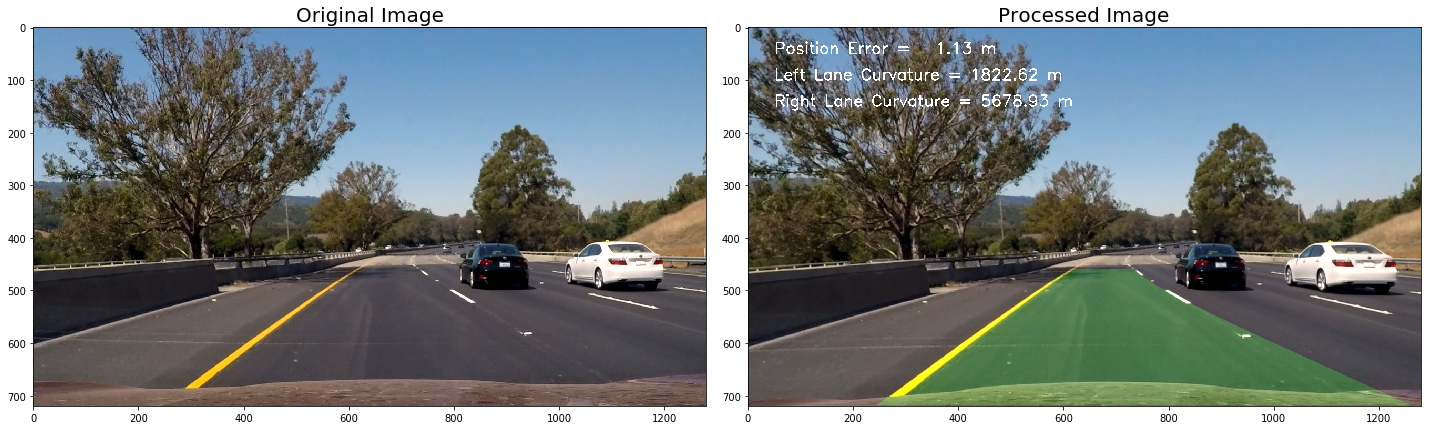

In [7]:
### 1- pipeline params
thresholds = {'SobelX':[0, 255], 'hls':[100, 255]}
left_line = line(720)
right_line = line(720)
# find lane pixels
n_ybin=10                              # Define constants for lane detection logic
sufficientHits = 500 # Minimum number of activated pixels within a region required
# compute position error
xm_per_pix = 3.7/700                            # meteres per pixel in x dimension
# compute lane curvature
ym_per_pix = 30/720                              # meters per pixel in y dimension

### 2-process image
#image = mpimg.imread('images/straight_lines1.jpg')
#image = mpimg.imread('images/straight_lines2.jpg')
#image = mpimg.imread('images/test1.jpg')
#image = mpimg.imread('images/test2.jpg')
#image = mpimg.imread('images/test3.jpg')
#image = mpimg.imread('images/test4.jpg')
#image = mpimg.imread('images/test5.jpg')
image = mpimg.imread('images/test6.jpg')
processed_image = pipeline(image, thresholds)

### 3- plotting
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,30))
fig.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image',fontsize=20)
ax2.imshow(processed_image)
ax2.set_title('Processed Image',fontsize=20)

### 2.3 Detected LaneBoundaries, LaneCurvature and VehiclePosition on moive

#### 2.31 Project Video 

In [8]:
from moviepy.editor import VideoFileClip

### 1- capture video as jpg images to process
vidcap = cv2.VideoCapture('videos/project_video.mp4')
success,image = vidcap.read()
count = 0
success = True
while success:
    success,image = vidcap.read()
    cv2.imwrite('capture/frame%d.jpg' % count, image)
    count += 1

### 2- define input and output path
completed_project = 'videos/completed_project.mp4'
clip1 = VideoFileClip('videos/project_video.mp4')

### 3- process video by pipeline, creat a process_video() to fits fl_image()
def process(image):
    return pipeline(image, thresholds)

white_clip = clip1.fl_image(process)
%time white_clip.write_videofile(completed_project, audio=False)

[MoviePy] >>>> Building video videos/completed_project.mp4
[MoviePy] Writing video videos/completed_project.mp4


100%|█████████████████████████████████████▉| 1260/1261 [02:47<00:00,  5.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos/completed_project.mp4 

Wall time: 2min 50s


In [9]:
from IPython.display import HTML
HTML('''
<video width='480' height='360' controls>
  <source src='{0}'>
</video>
'''.format(completed_project))

#### 2.32 Challenge Video

In [10]:
### 1- capture video as jpg images to process
vidcap = cv2.VideoCapture('videos/challenge_video.mp4')
success,image = vidcap.read()
count = 0
success = True
while success:
    success,image = vidcap.read()
    cv2.imwrite('capture/frame%d.jpg' % count, image)
    count += 1

### 2- define input and output path
completed_challenge = 'videos/completed_challenge.mp4'
clip2 = VideoFileClip('videos/challenge_video.mp4')

### 3- process video by pipeline, creat a process_video() to fits fl_image()
def process(image):
    return pipeline(image, thresholds)

white_clip2 = clip2.fl_image(process)
%time white_clip2.write_videofile(completed_challenge, audio=False)

[MoviePy] >>>> Building video videos/completed_challenge.mp4
[MoviePy] Writing video videos/completed_challenge.mp4


100%|████████████████████████████████████████| 485/485 [01:27<00:00,  5.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos/completed_challenge.mp4 

Wall time: 1min 29s


In [11]:
HTML('''
<video width='480' height='360' controls>
  <source src='{0}'>
</video>
'''.format(completed_challenge))

#### 2.33 Harder Challenge Video

In [12]:
### 1- capture video as jpg images to process
vidcap = cv2.VideoCapture('videos/harder_challenge_video.mp4')
success,image = vidcap.read()
count = 0
success = True
while success:
    success,image = vidcap.read()
    cv2.imwrite('capture/frame%d.jpg' % count, image)
    count += 1

### 2- define input and output path
completed_hchallenge = 'videos/completed_hchallenge.mp4'
clip3 = VideoFileClip('videos/harder_challenge_video.mp4')

### 3- process video by pipeline, creat a process_video() to fits fl_image()
def process(image):
    return pipeline(image, thresholds)

white_clip3 = clip3.fl_image(process)
%time white_clip3.write_videofile(completed_hchallenge, audio=False)

[MoviePy] >>>> Building video videos/completed_hchallenge.mp4
[MoviePy] Writing video videos/completed_hchallenge.mp4


100%|█████████████████████████████████████▉| 1199/1200 [03:55<00:00,  5.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos/completed_hchallenge.mp4 

Wall time: 3min 58s


In [13]:
HTML('''
<video width='480' height='360' controls>
  <source src='{0}'>
</video>
'''.format(completed_hchallenge))